<a href="https://colab.research.google.com/github/Pavun-KumarCH/Research-Notebooks/blob/main/Hybride_Search_VDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Search


In [9]:
#@title requirements.txt
%pip install --q pinecone sentence_transformers datasets pinecone_text

In [2]:
# load dependencies
import os
import torch
from io import BytesIO
from tqdm.auto import tqdm
from base64 import b64decode
from datasets import load_dataset
from IPython.display import HTML, Markdown
from pinecone_text.sparse import BM25Encoder # new Encoding Method
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

# Environments
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')

In [3]:
# Set-up Device & Pinecone

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

pinecone = Pinecone(api_key = PINECONE_API_KEY)

INDEX_NAME = "hybrid-search"

# Delete if already exists
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)

# Create Index
pinecone.create_index(
    name = INDEX_NAME,
    dimension = 512,
    metric = "dotproduct",
    spec = ServerlessSpec(cloud = 'aws', region = "us-east-1"))
index = pinecone.Index(INDEX_NAME)

Using device: cpu


In [10]:
# Load the Dataset
fashion = load_dataset("ashraq/fashion-product-images-small",
                       split = "train")
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [5]:
# Get the images
images = fashion["image"]
metadata = fashion.remove_columns("image")

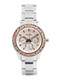

In [6]:
images[44071] # The Last Image

In [7]:
# convert the meta-data to pandas
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


## Create the Sparse Vector Using BM25

In [11]:
# Creating Sparse Vector's using BM25 Encoder
bm25 = BM25Encoder()
bm25.fit(metadata["productDisplayName"])
metadata['productDisplayName'][0]

  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

In [12]:
# sample of Ecode in both query & documents
bm25.encode_queries(metadata["productDisplayName"][0])
bm25.encode_documents(metadata["productDisplayName"][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Create the Dense Vector Using CLIP

In [ ]:
# Creating the Dense Vectors Using CLIP Encoder (OpenAI)
model = SentenceTransformer("sentence-transformers/clip-ViT-B-32",
                            device = device)
model
dense_vector = model.encode(metadata['productDisplayName'])
dense_vector.shape

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

(44072, 512)

In [ ]:
len(fashion)

44072

## Uploading the Embeddings in both Sparse and Dense to Pinecone VDB



> (Note: fashion_data_num = 1000): In this, we've initially set fashion_data_num to 1000 for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, consider increasing this value. You'll likely notice better and more relevant results.



In [ ]:
# Upserting the both Spaese and Dense Embeddings to the Pinecone

batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num, len(fashion)), batch_size)):

  # find end of the batch
  i_end = min(i+batch_size, len(fashion))

  # extract metadata batch
  meta_batch = metadata.iloc[i:i_end]
  meta_dict = meta_batch.to_dict(orient = "records")

  # concatinate all metadata field except for id and year to form a single string
  meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]

  # extract image batch
  img_batch = images[i:i_end]

  # create sparse BM25 vectors
  sparse_embeds = bm25.encode_documents([text for text in meta_batch])

  # create dense vectors
  dense_embeds = model.encode(img_batch).tolist()

  # create unique ID's
  ids = [str(x) for x in range(i, i_end)]

  upserts = []

  # loop through the data and create dictionaries for uploading documents to pinecone index
  for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
    upserts.append({
        'id': _id,
        'sparse_values': sparse,
        'values': dense,
        'metadata': meta})

  # upload the documents to the new hybrid index
  index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/10 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 3700}},
 'total_vector_count': 3700}

## Run Your Query

In [ ]:
query = "dark blue french connection jeans for men"

sparse = bm25.encode_queries(query)  # sparse query embed
dense = model.encode(query).tolist() # dense query embed

# Search the result in both embeds
result = index.query(top_k = 14,
                     vector = dense,
                     sparse_vector = sparse,
                     include_metadata = True)

imgs = [images[int(r['id'])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.Image.Image image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

In [ ]:
# Function to display product image
from base64 import b64encode

def display_image(image_batch):
  figures = []
  for image in image_batch:
    b = BytesIO()
    image.save(b, format = "png")

    figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px">
            </figure>
                  ''')
  return HTML(data = f'''
                      <div style="display: flex; flex-flow: row wrap; text-align: center;">
                      {''.join(figures)}
                      </div>''')


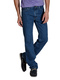
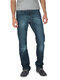
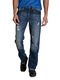
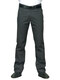
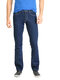
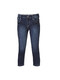
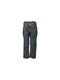
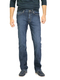
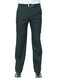
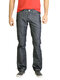
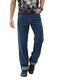
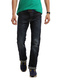
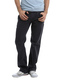
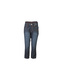

In [ ]:
display_image(imgs)

## Scaling the Hybrid Search

In [ ]:
# Hybride Search using the Alpha Confidence parameter
# Closer to 0 == more sparse, closer to 1 == more dense

def hybride_scale(dense, sparse, alpha: float):
  """
  Hybrid vector scaling using a convex combination

  alpha * dense + (1 - alpha) * sparse

  Args:
      dense: Array of floats representing
      sparse: a dict of `indices` and `values`
      alpha: float between 0 and 1 where 0 == sparse only and 1 == dense only
  """
  if alpha < 0 or alpha > 1:
    raise ValueError("Alpha must be between 0 and 1")

  # scale sparse and dense vectors to create hybrid search vecs
  hsparse = {
      'indices' :  sparse['indices'],
      'values' :  [v * (1 - alpha) for v in sparse['values']]
  }

  hdense = [v * alpha for v in dense]
  return hdense, hsparse

# 1. More Dense


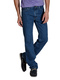
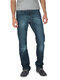
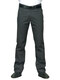
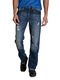
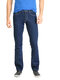
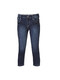

In [ ]:
questions = "dark blue french connection jeans for men"
dense, sparse = model.encode(questions), bm25.encode_queries(questions)

# Closer to 0 == more sparse, closer to 1 == more dense

hdense, hsparse = hybride_scale(dense, sparse, alpha = 1)
result = index.query(
    top_k = 6,
    vector = hdense,
    sparse_vector = hsparse,
    include_metadata = True)

imgs = [images[int(r['id'])] for r in result['matches']]
display_image(imgs)

In [ ]:
for x in result['matches']:
  print(x['metadata']['productDisplayName'])

John Players Men Blue Jeans
Peter England Men Party Blue Jeans
Indigo Nation Men ID Printed Grey Trousers
French Connection Men Blue Jeans
Locomotive Men Washed Blue Jeans
Gini and Jony Girls Woven Navy Blue Jeans


# 2. More Sparse


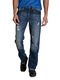
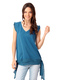
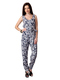
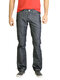
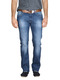
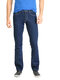

In [ ]:
questions = "dark blue french connection jeans for men"
dense, sparse = model.encode(questions), bm25.encode_queries(questions)

# Closer to 0 == more sparse, closer to 1 == more dense

hdense, hsparse = hybride_scale(dense, sparse, alpha = 0)
result = index.query(
    top_k = 6,
    vector = hdense,
    sparse_vector = hsparse,
    include_metadata = True)

imgs = [images[int(r['id'])] for r in result['matches']]
display_image(imgs)

In [ ]:
for x in result['matches']:
  print(x['metadata']['productDisplayName'])

French Connection Men Blue Jeans
French Connection Women Blue Top
French Connection Women Blue Jumpsuit
Locomotive Men Washed Blue Jeans
Lee Men Tino Blue Jeans
Locomotive Men Washed Blue Jeans


# More Dense or More Sparse?